# Question 1

In [4]:
import numpy as np
import time
from scipy.spatial import cKDTree

#Generate positions
def generate_positions(N, seed=2066):
    np.random.seed(seed)
    return np.random.uniform(0, 100, (N, 3))

#Direct acceleration calculator
def acceleration_direct(positions, G=1.0, m=1.0, softening=1e-9):
    N = positions.shape[0]
    
    # Compute differences between all pairs of points:
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
    
    # Compute particle distances, adding softening so we dont get infinity
    r = np.linalg.norm(diff, axis=2) + softening
    
    # remove self interaction by making the distance to self infinity
    np.fill_diagonal(r, np.inf)
    
    # Sum over all contributions for each particle
    acc = G * m * np.sum(diff / r[:, :, None]**3, axis=1)
    return acc

#KDTree acceleration calculator
def acceleration_kdtree(positions, cutoff=20, G=1.0, m=1.0, softening=1e-9):

    # I chose a cutoff of 20 above, because this will allow the nearest ~1/125th of the particles to interact, giving us a speedup in performance. 
    # The smaller the cutoff, the better the performance.
    
    # Initialize
    N = positions.shape[0]
    tree = cKDTree(positions)
    acc = np.zeros_like(positions)
    
    # Loop over particles 
    for i, pos in enumerate(positions):
        
        # Get indices of particles within cutoff 
        indices = tree.query_ball_point(pos, cutoff)
        
        # Remove the self-index
        indices = [j for j in indices if j != i]
        if len(indices) > 0:
            diffs = positions[indices] - pos
            r = np.linalg.norm(diffs, axis=1) + softening
            acc[i] = G * m * np.sum(diffs / r[:, None]**3, axis=0)
        else:
            acc[i] = np.zeros(3)
    return acc


# List of particle numbers to test

# For direct summation I limit to N=10^3 and 10^4 because of O(N^2) scaling, this will take too long and I won't be able to turn it in if I run all 4.
Ns_direct = [10**3, 10**4]
Ns_kdtree = [10**3, 10**4, 10**5]
  
print("Direct Method timings:")
for N in Ns_direct:
    positions = generate_positions(N)
    start = time.time()
    acc = acceleration_direct(positions)
    end = time.time()
    print(f"N={N}: Time = {end - start:.4f} seconds")
    
print("\nKDTree Method timings:")
for N in Ns_kdtree:
    positions = generate_positions(N)
    start = time.time()
    acc = acceleration_kdtree(positions)
    end = time.time()
    print(f"N={N}: Time = {end - start:.4f} seconds")
    
# For verification:
N_compare = 1000
positions = generate_positions(N_compare)
acc_direct = acceleration_direct(positions)
acc_kdtree = acceleration_kdtree(positions)
difference = np.linalg.norm(acc_direct - acc_kdtree, axis=1).mean()
print(f"\nMean difference between direct and KDTree accelerations for N={N_compare}: {difference:.3e}")


Direct Method timings:
N=1000: Time = 0.2274 seconds
N=10000: Time = 104.0528 seconds

KDTree Method timings:
N=1000: Time = 0.1731 seconds
N=10000: Time = 1.9897 seconds
N=100000: Time = 111.1330 seconds

Mean difference between direct and KDTree accelerations for N=1000: 2.757e-01


# Question 2

### Implementing Pyro

In [21]:
#imports
from pyro import Pyro
import matplotlib.pyplot as plt
import numpy as np

In [22]:
#list of solver variables
solvers = ["compressible", "compressible_rk","compressible_fv4","compressible_sdc"]
problem_name = "kh"
param_file = "inputs.kh"
velocities = [0,1,3,10]

In [23]:
#create and run sims for v_rel = 1
for v in velocities:
    extra_params = {'vis.dovis' : False, 'mesh.nx' : 128, 'mesh.ny' : 128, 'eos.gamma' : 1.7, 'kh.bulk_velocity' : v}
    count = 0
    for solver in solvers:
        sim = Pyro(solver)
        sim.initialize_problem(problem_name, inputs_file = param_file, inputs_dict = extra_params)
        print(f"Running solver {solver} for velocity {v}")
        sim.run_sim()
        print(f"Finished solver {solver} for velocity {v}")
        if count == 0:
            density = density = np.flipud(np.transpose(np.array(sim.get_var("density"))))
        else:
            density = np.append(density,np.flipud(np.transpose(np.array(sim.get_var("density")))),axis=1)
        count += 1
    if v == 0:
        densities = density
    else:
        densities = np.append(densities,density,axis=0)

Running solver compressible for velocity 0
Finished solver compressible for velocity 0
Running solver compressible_rk for velocity 0
Finished solver compressible_rk for velocity 0
Running solver compressible_fv4 for velocity 0
Finished solver compressible_fv4 for velocity 0
warning, key: compressible.limiter not defined
Running solver compressible_sdc for velocity 0
Finished solver compressible_sdc for velocity 0
Running solver compressible for velocity 1
Finished solver compressible for velocity 1
Running solver compressible_rk for velocity 1
Finished solver compressible_rk for velocity 1
Running solver compressible_fv4 for velocity 1
Finished solver compressible_fv4 for velocity 1
warning, key: compressible.limiter not defined
Running solver compressible_sdc for velocity 1
Finished solver compressible_sdc for velocity 1
Running solver compressible for velocity 3
Finished solver compressible for velocity 3
Running solver compressible_rk for velocity 3
Finished solver compressible_rk f

In [24]:
#create and run sims for v_rel = 10
for v in velocities:
    extra_params = {'vis.dovis' : False, 'mesh.nx' : 128, 'mesh.ny' : 128, 'eos.gamma' : 1.7, 'kh.u_1' : -5, 'kh.u_2' : 5, 'kh.bulk_velocity' : v}
    count = 0
    for solver in solvers:
        sim = Pyro(solver)
        sim.initialize_problem(problem_name, inputs_file = param_file, inputs_dict = extra_params)
        print(f"Running solver {solver} for velocity {v}")
        sim.run_sim()
        print(f"Finished solver {solver} for velocity {v}")
        if count == 0:
            density = density = np.flipud(np.transpose(np.array(sim.get_var("density"))))
        else:
            density = np.append(density,np.flipud(np.transpose(np.array(sim.get_var("density")))),axis=1)
        count += 1
    if v == 0:
        densities10 = density
    else:
        densities10 = np.append(densities,density,axis=0)

warning, key: compressible.limiter not defined
warning, key: compressible.limiter not defined
warning, key: compressible.limiter not defined
warning, key: compressible.limiter not defined


### Plotting

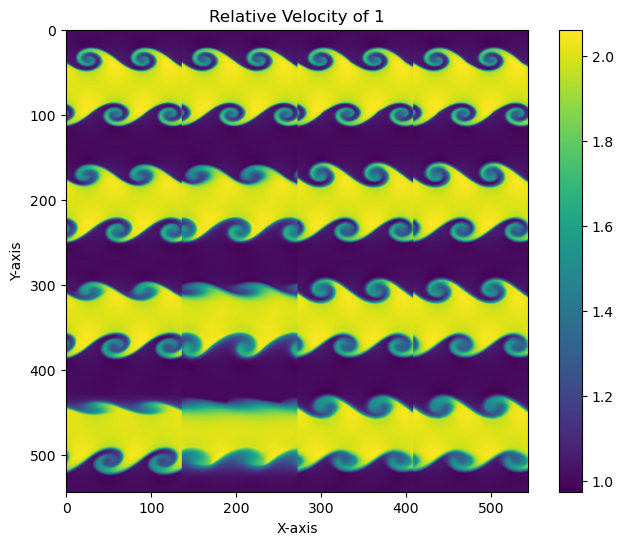

In [25]:
# Create heatmap for v_rel = 1
plt.figure(figsize=(8, 6))
plt.imshow(densities, cmap='viridis')
plt.title('Relative Velocity of 1')
plt.colorbar()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

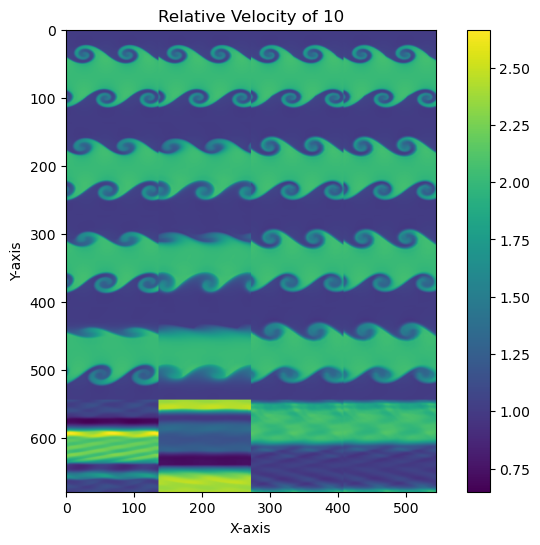

In [27]:
# Create heatmap for v_rel = 10
plt.figure(figsize=(8, 6))
plt.imshow(densities10, cmap='viridis')
plt.title('Relative Velocity of 10')
plt.colorbar()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()